In [1]:
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
import pylab as pl
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython.display import clear_output

sns.set_style("whitegrid")
sns.set(rc={'axes.facecolor':'#e6fdcb', 'figure.facecolor':'#b6d699'})

from scripts import *
from models import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
data = pd.read_csv("../Datasets/Avocado_prices_2020/avocado-updated-2020.csv", sep=",")

In [3]:
data.describe()

,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,year
count,33045.000000,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,33045.000000
mean,1.379941,9.683997e+05,3.023914e+05,2.797693e+05,2.148255e+04,3.646735e+05,2.501980e+05,1.067329e+05,7.742585e+03,2017.460887
std,0.378972,3.934533e+06,1.301026e+06,1.151052e+06,1.001607e+05,1.564004e+06,1.037734e+06,5.167226e+05,4.819803e+04,1.699747
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015.000000
25%,1.100000,1.511895e+04,7.673100e+02,2.712470e+03,0.000000e+00,9.121860e+03,6.478630e+03,4.662900e+02,0.000000e+00,2016.000000
50%,1.350000,1.291170e+05,1.099477e+04,2.343600e+04,1.780900e+02,5.322224e+04,3.687699e+04,6.375860e+03,0.000000e+00,2017.000000
75%,1.620000,5.058285e+05,1.190219e+05,1.352389e+05,5.096530e+03,1.744314e+05,1.206624e+05,4.041723e+04,8.044400e+02,2019.000000
max,3.250000,6.371614e+07,2.274362e+07,2.047057e+07,2.546439e+06,3.168919e+07,2.055041e+07,1.332760e+07,1.403184e+06,2020.000000


In [4]:
# Check null values
data.isnull().sum()

date             0
average_price    0
total_volume     0
4046             0
4225             0
4770             0
total_bags       0
small_bags       0
large_bags       0
xlarge_bags      0
type             0
year             0
geography        0
dtype: int64

In [5]:
# Convert date to datetime format
data["date"] = pd.to_datetime(data["date"])

In [6]:
# Sort data by date
data = data.sort_values(["date"], ascending=[True]) 

In [7]:
# Consider data of the whole US
avocado_us = data[data["geography"]=="Total U.S."]

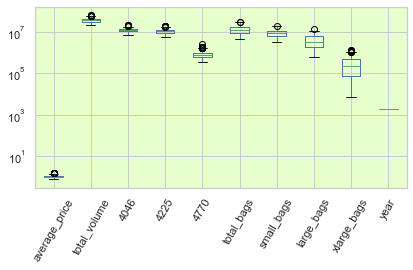

In [8]:
# Boxplot of the variables
with avocado_plot(color='#e6ffcc') as ax:
    avocado_us[avocado_us["type"]=="conventional"].plot.box(ax=ax, rot=60)
    ax.set_yscale("log")

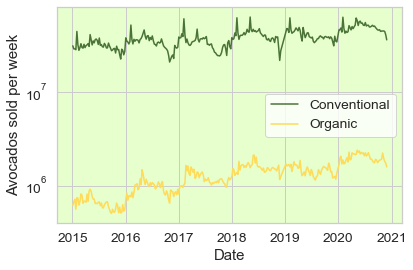

In [9]:
# Avocados sold per year
with avocado_plot(color='#e6ffcc') as ax:
    plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "total_volume"]], ax, legend=["Conventional"])
    plot_series(avocado_us[avocado_us["type"]=="organic"][["date", "total_volume"]], ax, legend=["Organic"])
    ax.set_yscale("log")
    pl.ylabel("Avocados sold per week")
    pl.tight_layout()

In [10]:
# Growth of avocado sales per year
from scipy.optimize import curve_fit

def f(x, c0, a):
    return c0*a**x

avocado_type = "organic"
c = avocado_us[avocado_us["type"]==avocado_type][["total_volume"]].to_numpy().ravel()

years = len(c) / 52.1429
xdata = np.linspace(0, years, c.shape[0])
popt, _ = curve_fit(f, xdata, c)
print(f"Growth of {avocado_type} avocado per year: {(popt[1] - 1)*100} %")

Growth of organic avocado per year: 19.91002931744401 %


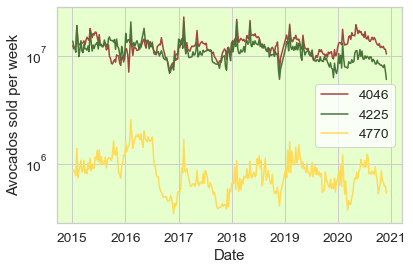

In [11]:
# Avocados sold by type over time
with avocado_plot(color='#e6ffcc') as ax:
    plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "4046", "4225", "4770"]], ax)
    ax.set_yscale("log")
    pl.ylabel("Avocados sold per week")

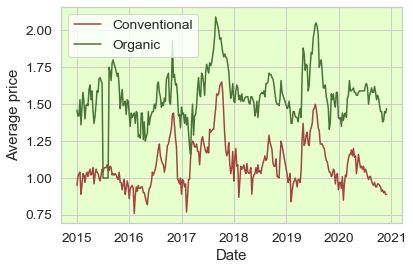

In [12]:
# Avocado price over time
with avocado_plot(color='#e6ffcc') as ax:
    plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "average_price"]], ax, legend=["Conventional"])
    plot_series(avocado_us[avocado_us["type"]=="organic"][["date", "average_price"]], ax, legend=["Organic"])
    pl.ylabel("Average price")

It seems that the Avocadopocalypse of 2017 was indeed real, the price grew to over 1.6$, a 50% increase from its mean of 1.08$

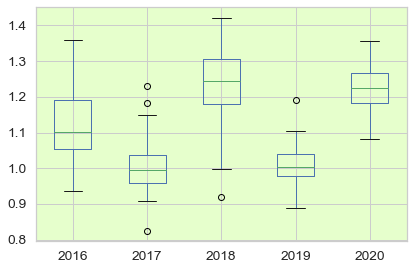

In [13]:
# Region by avocado sales
avocados_growth = pd.DataFrame(columns = set(data["geography"]))

for column in avocados_growth:
    region = data[(data["geography"]==column) & (data["type"]=="conventional")]
    avocados_per_year = region.groupby(region["date"].dt.year)["total_volume"].mean().to_numpy()
    avocados_growth[column] = avocados_per_year[1:] / avocados_per_year[:-1]

avocados_growth["year"] = np.sort(list(set(data["year"])))[1:]
avocados_growth = avocados_growth.set_index("year")

with avocado_plot(color='#e6ffcc') as ax:
    avocados_growth.T.plot.box(ax=ax)

## Gaussian process predictions

The power of the gaussian process is that it is hihly customizable by choosing different kernels or sum of kernels, furthermore it provides confidence bounds on predictions and any length predictions

In [60]:
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical
from IPython.display import clear_output
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, \
           ExpSineSquared, ConstantKernel, Matern

from sklearn.model_selection import TimeSeriesSplit

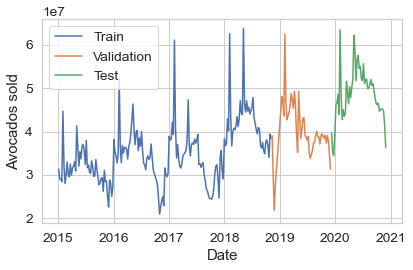

In [439]:
y = avocado_us[avocado_us["type"]=="conventional"][["total_volume"]].to_numpy()
t = avocado_us[avocado_us["type"]=="conventional"][["date"]].to_numpy().ravel()

t_train, t_test = t[:-52], t[-52:]
y_train, y_test = y[:-52], y[-52:]

t_train, t_val = t_train[:-52], t_train[-52:]
y_train, y_val = y_train[:-52], y_train[-52:]

with avocado_plot() as ax:
    ax.plot(t_train, y_train, label="Train")
    ax.plot(t_val, y_val, label="Validation")
    ax.plot(t_test, y_test, label="Test")
    ax.set_ylabel("Avocados sold")
    ax.set_xlabel("Date")
    ax.legend()

## Sales predictions

In [440]:
y = avocado_us[avocado_us["type"]=="conventional"][["total_volume"]].to_numpy()
x = np.arange(y.shape[0], dtype=float).reshape(-1, 1)

y *= 1e-7
x *= 1e-2

y_train, y_test = y[:-52], y[-52:]
x_train, x_test = x[:-52], x[-52:]

x_train, x_val = x_train[:-52], x_train[-52:]
y_train, y_val = y_train[:-52], y_train[-52:]

### Marginal Likelihood

In [441]:
def create_kernel(bounds=(1e-5, 1e5)):
    # General trend
    k1 = ConstantKernel() * Matern(1, bounds)
    # Year seasonality
    k2 = ConstantKernel() * Matern(1, bounds) * ExpSineSquared(1, 1, (1, 10), bounds)
    # Mid term irregularities
    k3 = ConstantKernel() * RationalQuadratic(alpha_bounds=(1e-9, 1e9))
    # Noise
    k4 = WhiteKernel()
    kernel = k1+k2+k3+k4

    return kernel

kernel = create_kernel(bounds=(1e-1, 1e2))
model = GaussianProcessRegressor(kernel, n_restarts_optimizer=0, normalize_y=True).fit(x[:-52], y[:-52])

S:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
S:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
S:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


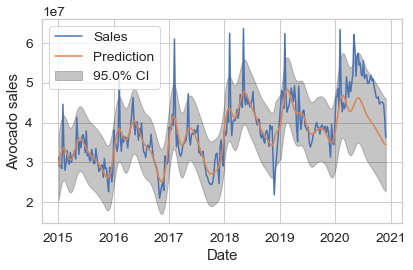

In [442]:
# Plot
y_pred, y_std = model.predict(x, return_std=True)

with avocado_plot() as ax:
    ax.plot(t, y*1e7, label="Sales")
    plot_CI(ax, t, y_pred*1e7, y_std*1e7, 0.95)
    ax.legend(loc="upper left")
    ax.set_ylabel("Avocado sales")
    ax.set_xlabel("Date")

In [443]:
# Average error
average_error(model.predict(x_test), y_test)

17.394881149410573

In [444]:
# Kernel
model.kernel_

0.454**2 * Matern(length_scale=0.1, nu=1.5) + 1.22**2 * Matern(length_scale=100, nu=1.5) * ExpSineSquared(length_scale=1, periodicity=0.519) + 0.979**2 * RationalQuadratic(alpha=1.28e+05, length_scale=1.82) + WhiteKernel(noise_level=0.321)

In [445]:
t_long = np.concatenate((t, np.array([t[-1] + i*np.timedelta64(7,'D') for i in range(1, 52*5)])))
x_long = np.concatenate((x, np.array([x[-1] + i for i in range(1, 52*5)])))

### Bayesian optimization

In [459]:
space  = [Real(1e-3, 1e3, "log-uniform", name='k1_constant'),
          Real(1e-3, 1e3, "log-uniform", name='k1_lengthscale'),
          Categorical([0.5, 1.5, 2.5, np.inf], name="k1_nu"),

          Real(1e-3, 1e3, "log-uniform", name='k2_constant'),
          Real(1e-3, 1e3, "log-uniform", name='k2_lengthscale'),
          Categorical([0.5, 1.5, 2.5, np.inf], name="k2_nu"),
          Real(1e-1, 1e2, "log-uniform", name='k2_sine_lengthscale'),
          Categorical([0.52, 1.04], name='k2_periodicity'),

          Real(1e-3, 1e3, "log-uniform", name='k3_constant'),
          Real(1e-3, 1e3, "log-uniform", name='k3_lengthscale'),
          Real(1e-8, 1e8, "log-uniform", name='k3_alpha')]

def create_fixed_kernel(params, bounds="fixed"):
    # General trend
    k1 = ConstantKernel(params["k1_constant"], bounds) * Matern(params["k1_lengthscale"], bounds, params["k1_nu"])
    # Year seasonality
    k2 = ConstantKernel(params["k2_constant"], bounds) * Matern(params["k2_lengthscale"], bounds, params["k2_nu"]) \
         * ExpSineSquared(params["k2_sine_lengthscale"], params["k2_periodicity"], bounds, bounds)
    # Mid term irregularities
    k3 = ConstantKernel(params["k3_constant"], bounds) * RationalQuadratic(params["k3_lengthscale"], params["k3_alpha"], bounds, bounds)
    # Noise
    k4 = WhiteKernel()
    
    return k1 + k2 + k3 + k4

@use_named_args(space)
def objective(**params):
    clear_output(wait=True)

    kernel = create_fixed_kernel(params)

    tscv = TimeSeriesSplit(n_splits=4, test_size=52)
    loss = 0.
    for train_index, test_index in tscv.split(x[:-52]):
        x_tr, x_te = x[train_index], x[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        model = GaussianProcessRegressor(kernel, n_restarts_optimizer=0, normalize_y=True).fit(x_tr, y_tr)
        y_pred = model.predict(x_te)
        loss += np.mean((y_pred - y_te)**2)
    
    return loss

res_gp = gp_minimize(objective, space, n_calls=30, verbose=True, n_jobs=1, kappa=4)

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 1.1373
Function value obtained: 2.4710
Current minimum: 1.5306


In [460]:
kernel = create_fixed_kernel(params_to_dict(space, res_gp))
model = GaussianProcessRegressor(kernel, n_restarts_optimizer=1, normalize_y=True).fit(x[:-52], y[:-52])

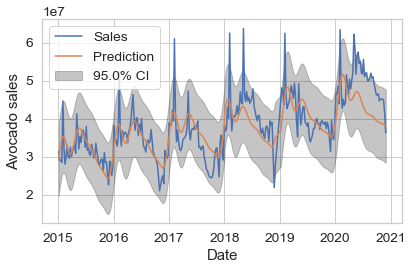

In [463]:
# Plot
y_pred, y_std = model.predict(x, return_std=True)

with avocado_plot() as ax:
    ax.plot(t, y*1e7, label="Sales")
    plot_CI(ax, t, y_pred*1e7, y_std*1e7, 0.95)
    ax.legend(loc="upper left")
    ax.set_ylabel("Avocado sales")
    ax.set_xlabel("Date")

In [322]:
# Average error
average_error(model.predict(x_test), y_test)

14.839882330670658

In [453]:
# Kernel
model.kernel_

0.436**2 * Matern(length_scale=0.0194, nu=0.5) + 6.02**2 * Matern(length_scale=11.8, nu=1.5) * ExpSineSquared(length_scale=8.95, periodicity=0.52) + 0.0316**2 * RationalQuadratic(alpha=2.01e-05, length_scale=38.3) + WhiteKernel(noise_level=0.233)

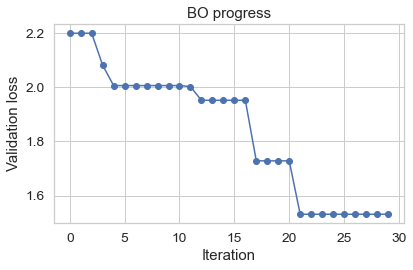

In [464]:
from skopt.plots import plot_convergence

with avocado_plot() as ax:
    ax.plot(sliding_minimum(res_gp.func_vals), "o-")
    ax.set_ylabel("Validation loss")
    ax.set_xlabel("Iteration")
    ax.set_title("BO progress")

## Price predictions

In [349]:
y = avocado_us[avocado_us["type"]=="conventional"][["average_price"]].to_numpy()
x = np.arange(y.shape[0], dtype=float).reshape(-1, 1)

x *= 1e-2

y_train, y_test = y[:-52], y[-52:]
x_train, x_test = x[:-52], x[-52:]

x_train, x_val = x_train[:-52], x_train[-52:]
y_train, y_val = y_train[:-52], y_train[-52:]

### Marginal Likelihood

In [424]:
def create_kernel(bounds=(1e-5, 1e5)):
    # General trend
    k1 = ConstantKernel() * Matern(1, bounds)
    # Year seasonality
    k2 = ConstantKernel() * Matern(1, bounds) * ExpSineSquared()
    # Mid term irregularities
    k3 = ConstantKernel() * RationalQuadratic(alpha_bounds=(1e-9, 1e9))
    # Noise
    k4 = WhiteKernel(1, (1e-1, 1e1))
    kernel = k1+k2+k3+k4

    return kernel

kernel = create_kernel(bounds=(1e-5, 1e5))
model = GaussianProcessRegressor(kernel, n_restarts_optimizer=1, normalize_y=True).fit(x[:-52], y[:-52])

S:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


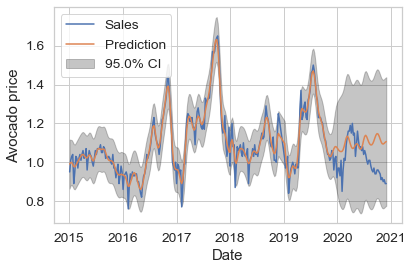

In [425]:
# Plot
y_pred, y_std = model.predict(x, return_std=True)

with avocado_plot() as ax:
    ax.plot(t, y, label="Sales")
    plot_CI(ax, t, y_pred, y_std, 0.95)
    ax.legend(loc="upper left")
    ax.set_ylabel("Avocado price")
    ax.set_xlabel("Date")

In [396]:
# Average error
average_error(model.predict(x_test), y_test)

11.738234712876316

In [397]:
# Kernel
model.kernel_

1.1**2 * Matern(length_scale=3.26e+03, nu=1.5) + 0.0532**2 * Matern(length_scale=1.35, nu=1.5) * ExpSineSquared(length_scale=0.0456, periodicity=1.49) + 0.16**2 * RationalQuadratic(alpha=0.858, length_scale=0.0594) + WhiteKernel(noise_level=0.000878)

In [358]:
t_long = np.concatenate((t, np.array([t[-1] + i*np.timedelta64(7,'D') for i in range(1, 52*5)])))
x_long = np.concatenate((x, np.array([x[-1] + i for i in range(1, 52*5)])))

### Bayesian optimization

In [401]:
space  = [Real(1e-3, 1e3, "log-uniform", name='k1_constant'),
          Real(1e-3, 1e3, "log-uniform", name='k1_lengthscale'),
          Categorical([0.5, 1.5, 2.5, np.inf], name="k1_nu"),

          Real(1e-3, 1e3, "log-uniform", name='k2_constant'),
          Real(1e-3, 1e3, "log-uniform", name='k2_lengthscale'),
          Categorical([0.5, 1.5, 2.5, np.inf], name="k2_nu"),
          Real(1e-1, 1e2, "log-uniform", name='k2_sine_lengthscale'),
          Categorical([0.52, 1.04], name='k2_periodicity'),

          Real(1e-3, 1e3, "log-uniform", name='k3_constant'),
          Real(1e-3, 1e3, "log-uniform", name='k3_lengthscale'),
          Real(1e-8, 1e8, "log-uniform", name='k3_alpha')]


@use_named_args(space)
def objective(**params):
    clear_output(wait=True)

    kernel = create_fixed_kernel(params)

    tscv = TimeSeriesSplit(n_splits=4, test_size=52)
    loss = 0.
    for train_index, test_index in tscv.split(x[:-52]):
        x_tr, x_te = x[train_index], x[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        model = GaussianProcessRegressor(kernel, n_restarts_optimizer=0, normalize_y=True).fit(x_tr, y_tr)
        y_pred = model.predict(x_te)
        loss += np.mean(np.abs(y_pred - y_te))

    return loss

res_gp = gp_minimize(objective, space, n_calls=20, verbose=True, n_jobs=1)

S:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
S:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
S:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
S:\Anaconda\lib\site-packages\sklearn\ga

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.0164
Function value obtained: 0.5944
Current minimum: 0.5657


In [402]:
kernel = create_fixed_kernel(params_to_dict(space, res_gp))
model1 = GaussianProcessRegressor(kernel, n_restarts_optimizer=1, normalize_y=True).fit(x[:-52], y[:-52])

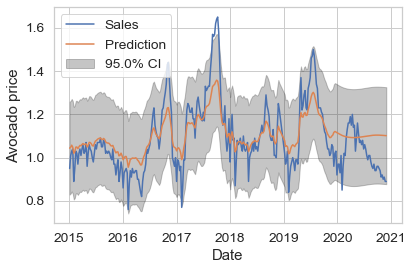

In [408]:
# Plot
y_pred, y_std = model1.predict(x, return_std=True)

with avocado_plot() as ax:
    ax.plot(t, y, label="Sales")
    plot_CI(ax, t, y_pred, y_std, 0.95)
    ax.legend(loc="upper left")
    ax.set_ylabel("Avocado price")
    ax.set_xlabel("Date")

In [404]:
# Average error
average_error(model1.predict(x_test), y_test)

12.328200002980559

In [387]:
# Kernel
model1.kernel_

0.0316**2 * Matern(length_scale=0.001, nu=0.5) + 0.344**2 * Matern(length_scale=2.24, nu=0.5) * ExpSineSquared(length_scale=0.1, periodicity=1.04) + 31.6**2 * RationalQuadratic(alpha=1e-08, length_scale=1e+03) + WhiteKernel(noise_level=0.4)

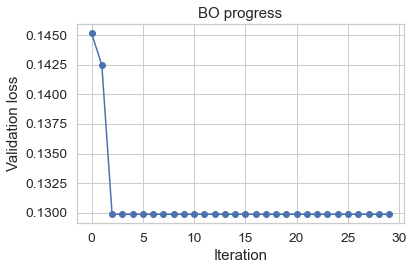

In [369]:
from skopt.plots import plot_convergence

with avocado_plot() as ax:
    ax.plot(sliding_minimum(res_gp.func_vals), "o-")
    ax.set_ylabel("Validation loss")
    ax.set_xlabel("Iteration")
    ax.set_title("BO progress")